In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

dir_proc_files = '/home/data/lab_hardik/heatwaves/ERA5/analyses/DSE/processed_files/'
output_dir='/home/scratch/Abel_data/hw_processed/ctrl/'

T95=3.4
T90=2.7

from sympl import get_constant
import metpy
from metpy.units import units


Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

In [2]:
var1=xr.open_dataset(dir_proc_files + 'NI_basic_vars_1980_1994.nc').sel({'isobaricInhPa':slice(500, 975)})
var2=xr.open_dataset(dir_proc_files + 'NI_basic_vars_1995_2009.nc').sel({'isobaricInhPa':slice(500, 975)})
var3=xr.open_dataset(dir_proc_files + 'NI_basic_vars_2010_2022.nc').sel({'isobaricInhPa':slice(500, 975)})

ds=xr.merge([var1,var2,var3])
# T=var1.sel({'isobaricInhPa':slice(900, 975)})
ds=ds.rename({'latitude':'lat', 'longitude':'lon', 'date':'time', 'isobaricInhPa':'lev'})
ds

/tmp/ipykernel_2701803/1802861202.py:1: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  var1=xr.open_dataset(dir_proc_files + 'NI_basic_vars_1980_1994.nc').sel({'isobaricInhPa':slice(500, 975)})
/tmp/ipykernel_2701803/1802861202.py:2: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which

<xarray.Dataset> Size: 9GB
Dimensions:                 (lev: 13, lat: 29, lon: 41, time: 5246)
Coordinates:
  * lev                     (lev) float64 104B 500.0 600.0 700.0 ... 950.0 975.0
  * lat                     (lat) float64 232B 24.0 24.25 24.5 ... 30.75 31.0
  * lon                     (lon) float64 328B 68.0 68.25 68.5 ... 77.75 78.0
  * time                    (time) datetime64[ns] 42kB 1980-03-01 ... 2022-06-30
    number                  int64 8B 0
    step                    timedelta64[ns] 8B 00:00:00
Data variables: (12/24)
    t                       (time, lev, lat, lon) float32 324MB 260.2 ... 299.1
    u                       (time, lev, lat, lon) float32 324MB 23.32 ... 0.0...
    v                       (time, lev, lat, lon) float32 324MB -6.436 ... 0.244
    w                       (time, lev, lat, lon) float32 324MB 0.08334 ... -...
    density                 (lev, time, lat, lon) float64 649MB 0.6696 ... 1.136
    z                       (time, lev, lat, lon) float32 324MB 5.651e+04 ......
    ...                      ...
    ni_southBndry_heat_in   (time, lev) float64 546kB nan nan ... 1.18e+06
    ni_northBndry_heat_out  (time, lev) float64 546kB nan nan ... 6.406e+05
    net_heat_flux_x         (time, lev) float64 546kB nan nan ... 9.533e+05
    net_heat_flux_y         (time, lev) float64 546kB nan nan ... 5.397e+05
    net_heat_flux_xy        (time, lev) float64 546kB nan nan ... 1.493e+06
    net_heat_flux_z         (lev, time, lat, lon) float64 649MB nan ... -46.65

In [16]:
hw_index=1
hw_master={'index':[],'time':[], 'T':[],
              'intensity':[], 'duration':[], 'maximum':[]}

for y in range(1980, 2022):
    T_yr=T.sel(date=T.date.dt.year == y)
    T_anom=T_yr.groupby('date.month')-T_yr.groupby('date.month').mean(dim='date')
    weights=np.cos(np.radians(T_anom.latitude))
    t_run=T_anom['t'].sel({'isobaricInhPa':975}).weighted(weights).mean(dim=('latitude', 'longitude'))-T90
    
    temp_time=[]
    temp_intensity=[]
    l_curr=0
    for i in range(len(t_run)):
        if t_run[i]>0:
            if len(temp_time)==0:
                temp_time.append(t_run.date[i-1]); temp_intensity.append(t_run[i-1]) 
            temp_time.append(t_run.date[i]); temp_intensity.append(t_run[i]) 
            l_curr=l_curr+1
        else:
            if l_curr>=3:
                temp_time.append(t_run.date[i]); temp_intensity.append(t_run[i]) 

                temp_time = np.array([t.values for t in temp_time])
                temp_intensity = np.array([t.values for t in temp_intensity])
                heat=temp_intensity.copy()

                st=1-heat[0]/(heat[0]-heat[1]); end=heat[-2]/(heat[-2]-heat[-1])
                heat[0]=0;heat[-1]=0
                dur_weight=np.ones(len(heat)-1); dur_weight[0]=st;dur_weight[-1]=end
                intensity=np.average((heat[1:]+heat[:-1])/2,weights=dur_weight)
                mx=np.max(heat[1:-1])
                dur=len(heat[1:-1])-1+st+end

                if dur>=3:
                    hw_master['index'].append(hw_index)
                    hw_master['time'].append(temp_time)
                    hw_master['T'].append(temp_intensity)
                    hw_master['intensity'].append(intensity.item())
                    hw_master['duration'].append(dur.item())
                    hw_master['maximum'].append(mx.item())
                    hw_index=hw_index+1


            l_curr=0
            temp_intensity=[]
            temp_time=[]
    
output_file=output_dir+'hw_reanalysis'
if not os.path.isfile(output_file):
    with open(output_file, 'wb') as f:
        pickle.dump(hw_master, f)

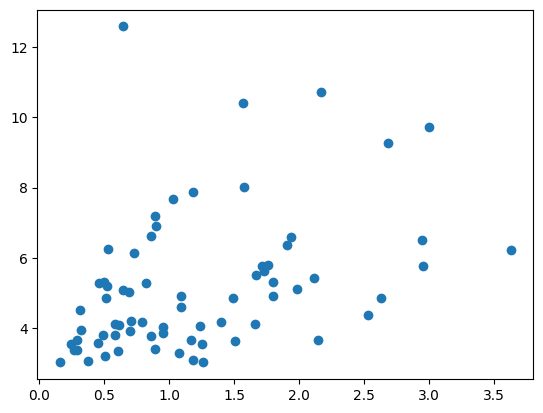

In [8]:
plt.scatter(hw_master['intensity'], hw_master['duration'])

In [35]:
dp=2500
Lx=np.radians(0.25)*6371*1000
Ly=np.radians(0.25)*6371*1000

def compute_dse(ds):
    
    lat_rad=np.radians(ds['t'].lat)
    
    dse=((Cp*ds['t']+g*ds['z'])*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lev':slice(880, 980)})
    return dse.sum(dim=('lat', 'lon','lev'))

def compute_dse_tend(ds):
    
    lat_rad=np.radians(ds['t'].lat)
    
    dse=Cp*ds['t']+g*ds['z']
    dsew=metpy.calc.first_derivative(dse, axis='lev')*units.hectopascal/units.metre
    dsex=metpy.calc.first_derivative(dse, axis='lon')
    dsey=metpy.calc.first_derivative(dse, axis='lat')
    dse_tend=-dsey*ds['v']-dsex*ds['u']-dsew*ds['w']/864
    dse_tend=(dse_tend*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lev':slice(880, 980)}).sum(dim=('lat', 'lon','lev'))*86400
    if (dse_tend.cumsum().mean(dim='time').item()):
#         dse_tend.plot()
        return dse_tend, True
    return dse_tend, False
                                                                                                
    
output_file=output_dir+'hw_reanalysis'
with open(output_file, 'rb') as f:
    hw_master=pickle.load(f)
    
hw_index=1

y=1
dse_master={'index':[], 'T':[], 'lonc':[], 'dse_low':[], 'dse_tend_low':[],
              'intensity':[], 'duration':[], 'maximum':[]}
full_length=70
# while hw_index<=len(hw_master['index']):
while hw_index<=full_length:

    time_slice=hw_master['time'][hw_index-1]
    ds_hw=ds.sel({'time':time_slice})
#     print(hw_index)
     
    dse_low=compute_dse(ds_hw)
    dse_tend_low, check=compute_dse_tend(ds_hw)
#     print(check)
    if check:
        dse_master['dse_low'].append(dse_low)
        dse_master['dse_tend_low'].append(dse_tend_low)
        for e in hw_master.keys():
            if e in dse_master.keys():
                dse_master[e].append(hw_master[e][hw_index-1])

    hw_index=hw_index+1
            
# print(dse_master)

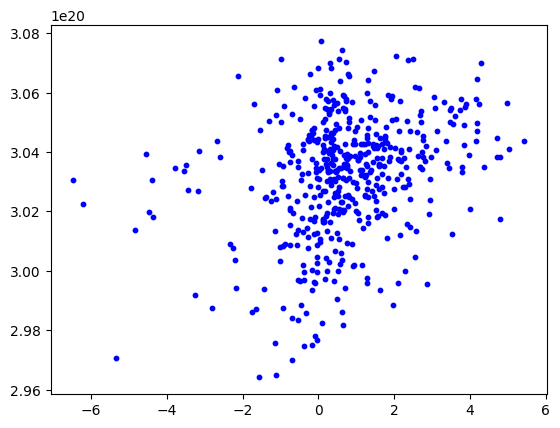

In [36]:
for i in range(len(dse_master['index'])):
    plt.scatter(dse_master['T'][i], dse_master['dse_low'][i], color='blue', s=10)

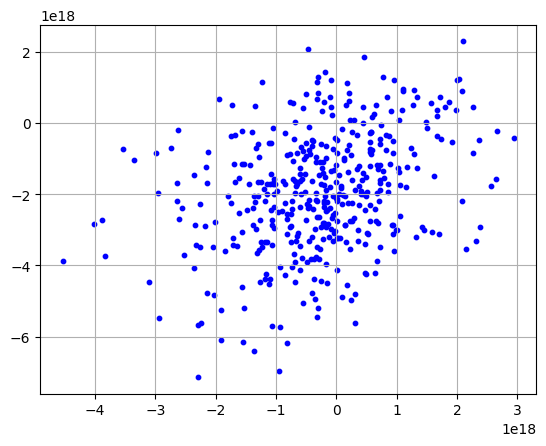

In [37]:
for i in range(len(dse_master['index'])):
    dse=dse_master['dse_low'][i].values[:]
    dse_diff=(dse[1:]-dse[:-1])
    dse=dse_master['dse_tend_low'][i].values[:]
    dse_tend=((dse[1:]+dse[:-1])/2)
    plt.scatter(dse_diff, dse_tend, color='blue', s=10)
plt.grid()
# xy=np.array([-1,0,1])*1e19
# plt.plot(xy, xy, linestyle='--')

In [43]:
# tot=[]
# for y in range(1980, 2022):
#     T_yr=T.sel(date=T.date.dt.year == y)
#     T_anom=T_yr.groupby('date.month')-T_yr.groupby('date.month').mean(dim='date')
#     weights=np.cos(np.radians(T_anom.latitude))
#     t_run=T_anom['t'].sel({'isobaricInhPa':975}).weighted(weights).mean(dim=('latitude', 'longitude'))
#     tot.append(t_run.values[:])
    
# np.nanquantile(tot, 0.90)

np.float64(2.7737126145215862)